# Test on Unsupervised 48-hours long dataset the Optimized Parameters

Some tips: use feather files to save large dataset 
Load trimmed dataset once the trimming is done (ie trim only once if possible) 

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from datetime import *
from imu_video_synch import *
from zurich_move_data_extraction import *
from utilities import *
from activity_count_function import *
from individual_analysis_ac_functions import *
from group_analysis_functions import *
from test_48h_dataset import *
from gm_function import gm_algorithm, compute_euler_angles, plot_angles_over_time

C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# CHANGE VALUES HERE #

participant_id = 'H006'
affected_hand = 'left'

# Number of IMU worn 
# 2 = both wrists 
# 3 = both wrists + chest 
num_sensors = 3

# Timestamps for start and end: extarcted from the excel sheet filled by the hospital
# Year Month Day 
# If None then no trimming 

start_date = '2023-07-20 10:23:13.500'
end_date = '2023-07-20 10:36:00.520'

# PATHS to get the IMU mat file # 
initial_path = '../CreateStudy'
participant_path = os.path.join(initial_path, participant_id)
imu_path = os.path.join(participant_path, participant_id + '.mat')

In [3]:
if affected_hand.lower() == 'left':
    non_affected_hand = 'right'
else: 
    non_affected_hand = 'left'

In [4]:
initial_path, participant_path, imu_path

('../CreateStudy', '../CreateStudy\\H006', '../CreateStudy\\H006\\H006.mat')

In [5]:
# Create a dict to save data on the tested participant 
# Will be saved as a JSON later, usefull to avoid recomputing everything each time 
participant_dataset = {
    'participant_id': participant_id,
    'affected_hand':affected_hand
}

In [6]:
# PATH to save figures 
figures_path = '../CreateStudy/figures'
testing_figures_path = os.path.join(figures_path, f"testing_{participant_id}")
# Invoke the create_folder function to create the directory
create_folder(testing_figures_path)

In [7]:
# Define the sensor placements, sensor features, and dataframe features
sensor_placement = ['LW', 'chest', 'RW']
matlab_sensor_features = ['acc', 'gyro', 'quat', 'accHiG', 'magneto', 'press']
sensor_features = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'quat_0', 'quat_1', 'quat_2',
                   'quat_3', 'accHiG_x', 'accHiG_y', 'accHiG_z', 'magneto_x', 'magneto_y', 'magneto_z', 'press']
sensor_9DOF_features = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ',
                       'magnetoX', 'magnetoY', 'magnetoZ']
sensor_acc_features =  ['acc_x', 'acc_y', 'acc_z']

# Constants related to thresholds
conventional_functional_space = 30
conventional_threshold_unilateral = 2  # Bailey and Lang, 2013
conventional_threshold_bilateral = 0  # Bailey and Lang, 2013

# Constants related to metric frequencies
frequency_imu = 50  # Hz
frequency_gm = 2   # Hz
frequency_gmac = 1  # Hz
frequency_AC = 1 # Hz 

In [8]:
# Extract and trim the data to match the correct timestamps 
ndh_data, trimmed_chest_data, dh_data = get_data_48h_imu(participant_path, imu_path, start_date, end_date, affected_hand, sensor_placement, matlab_sensor_features, sensor_features, num_sensors, frequency_imu)

Successfully loaded the Feather files into DataFrames.


In [9]:
# COMPUTATION PART# 

In [10]:
# Get useful variables for further computation
acc_ndh = ndh_data[['acc_x', 'acc_y', 'acc_z']]
acc_dh = dh_data[['acc_x', 'acc_y', 'acc_z']]
gyro_ndh = ndh_data[['gyro_x', 'gyro_y', 'gyro_z']]
gyro_dh = dh_data[['gyro_x', 'gyro_y', 'gyro_z']]
mag_ndh = ndh_data[['magneto_x', 'magneto_y', 'magneto_z']]

In [11]:
# Compute Brond Actigraph Activity Count 
# source code here: https://github.com/jbrond/ActigraphCounts/blob/master/R/Python_G_to_sec.py
count_brond_ndh, processed_data_ndh = get_counts_brond(ndh_data)
count_brond_dh, processed_data_dh = get_counts_brond(dh_data)
AC_ndh = np.array(count_brond_ndh['AC Brond'])
AC_dh = np.array(count_brond_dh['AC Brond'])

In [12]:
# Add AC to participant dataset 
add_attributes_to_participant(participant_dataset, AC_NDH = AC_ndh, AC_DH = AC_dh)

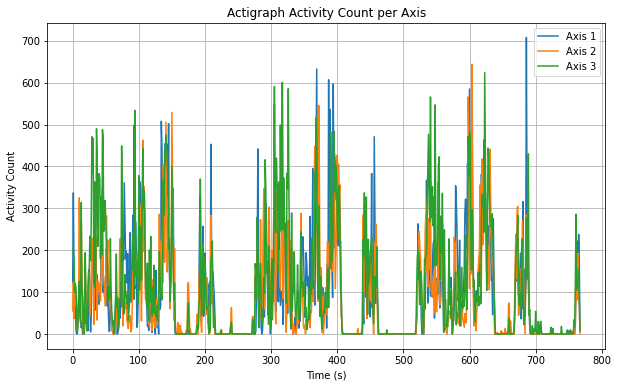

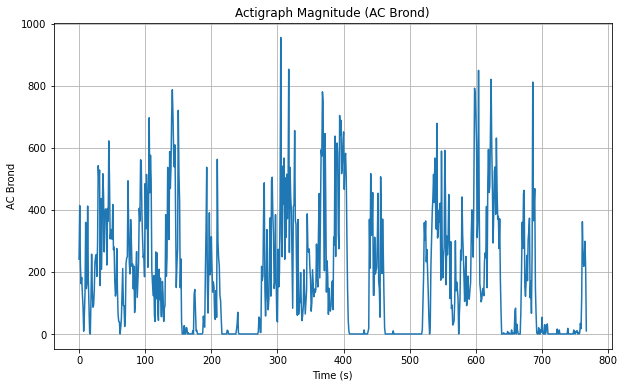

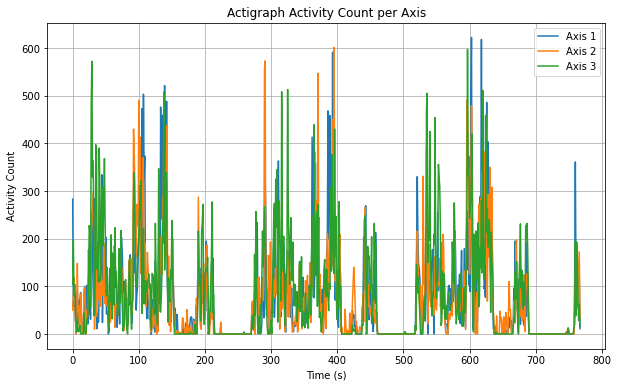

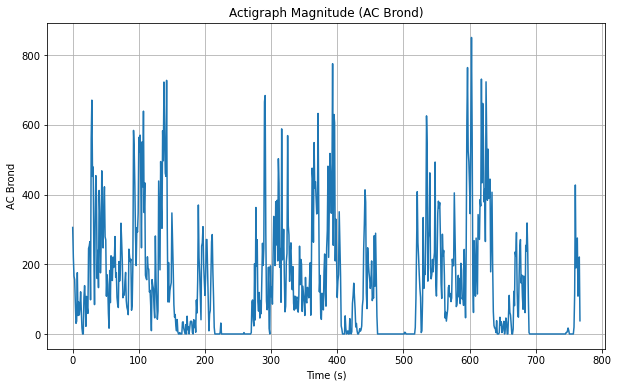

(None, None)

In [13]:
plot_actigraph_count(count_brond_ndh), plot_actigraph_count(count_brond_dh)

In [14]:
# Laterality metrics #

In [15]:
# Bilateral Magnitude 
bilateral_magnitude = compute_bilateral_magnitude(AC_ndh, AC_dh)
magnitude_ratio = get_magnitude_ratio(AC_ndh, AC_dh)

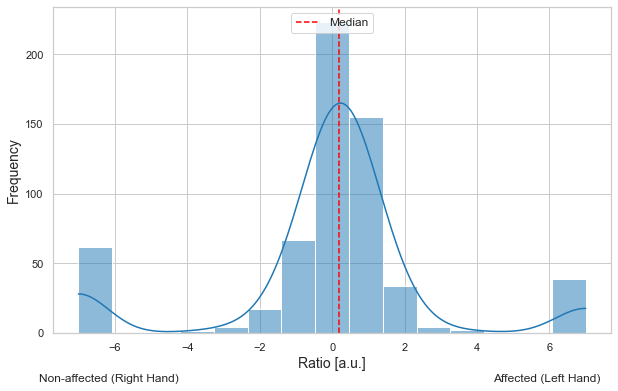

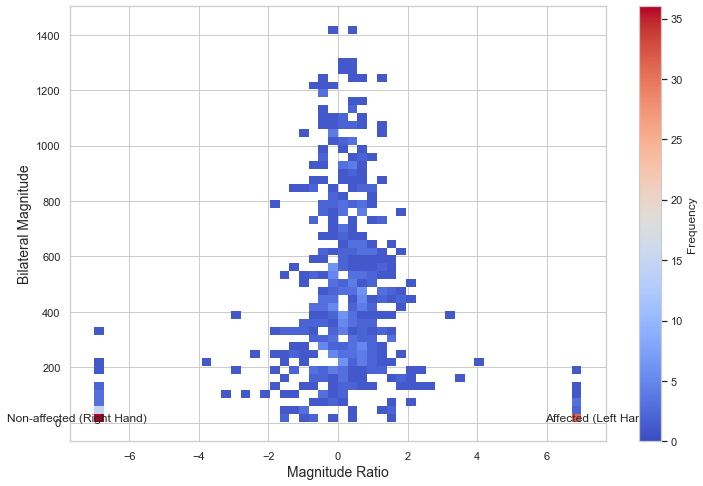

In [16]:
plot_distribution_ratio(magnitude_ratio, non_affected_hand = non_affected_hand, saving_path = None)
plot_density(bilateral_magnitude, magnitude_ratio, non_affected_hand = non_affected_hand, saving_path = None)

In [17]:
## GM Algorithm Computation ##

In [18]:
# Get Euler angles usign Madgwick sensor fusiona algorithm 
# Using only accel. and gyro 
# MARG use also magnetometer but after testing, it was less precise 
# Left wrist
roll_mad_ndh, pitch_mad_ndh, yaw_mad_ndh = compute_euler_angles(acc_ndh, gyro_ndh, frequency_imu)
# Right wrist 
roll_mad_dh, pitch_mad_dh, yaw_mad_dh = compute_euler_angles(acc_dh, gyro_dh, frequency_imu)

Using IMU Madgwick with acc and gyro only
Using IMU Madgwick with acc and gyro only


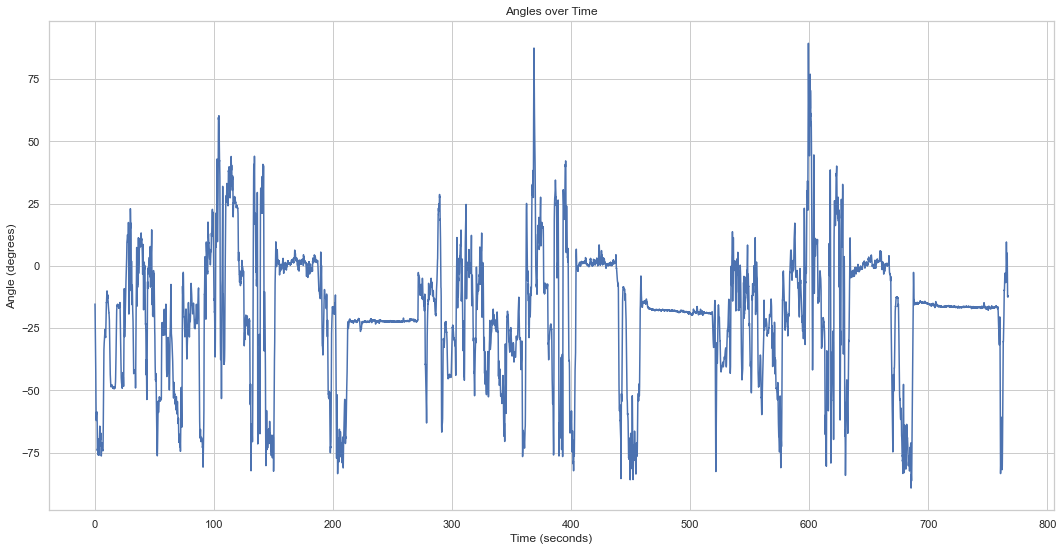

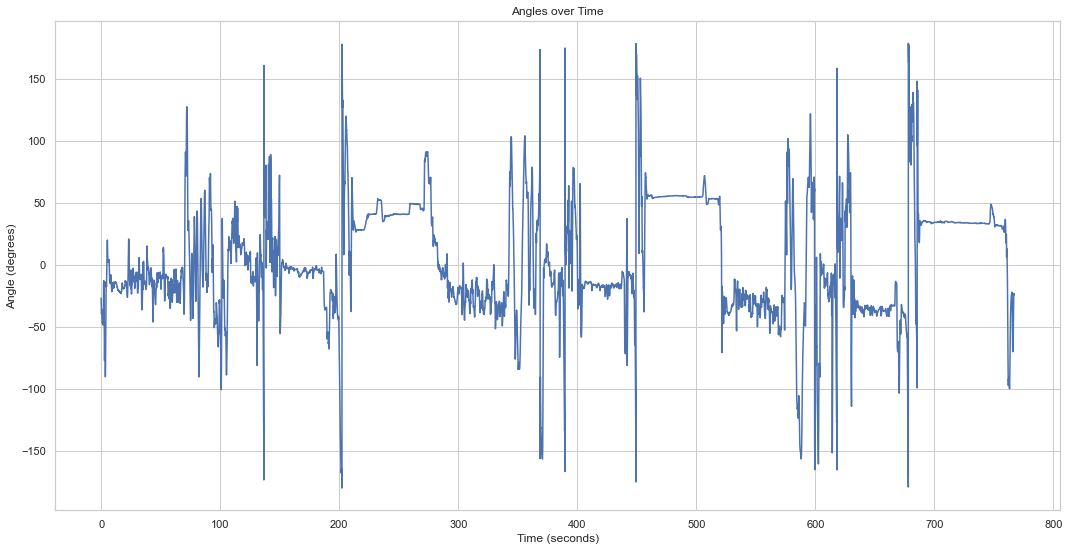

(None, None)

In [19]:
plot_angles_over_time(pitch_mad_dh), plot_angles_over_time(yaw_mad_dh)

In [20]:
# Add Euler angles to participant dataset 
add_attributes_to_participant(participant_dataset, pitch_NDH = pitch_mad_ndh, pitch_DH = pitch_mad_dh,
                              yaw_NDH = yaw_mad_ndh,yaw_DH = yaw_mad_dh)

In [21]:
# TESTING PART # 

In [22]:
# Load Optimal Healthy Group Parameters found so far #
# ie the optimal parameters we want to test using the 48h unseen dataset # 
initial_path_thresh = '../CreateStudy'
ac_threshold_file = 'H_optimal_threshold_AC.csv'
fs_threshold_file = 'H_optimal_threshold_GM.csv'
ac_threshold_path = os.path.join(initial_path_thresh, ac_threshold_file)
fs_threshold_path = os.path.join(initial_path_thresh, fs_threshold_file)
group_optimal_AC_NDH, group_optimal_AC_DH = load_threshold_from_csv(ac_threshold_path)
group_optimal_FS_NDH, group_optimal_FS_DH = load_threshold_from_csv(fs_threshold_path)
print(group_optimal_AC_NDH, group_optimal_AC_DH, group_optimal_FS_NDH, group_optimal_FS_DH)

24.0 11.6 53 53


In [23]:
# Create a dict to store all the thresholds: optimal and conventional 
thresholds = {
    'group_AC_NDH': group_optimal_AC_NDH,
    'group_AC_DH': group_optimal_AC_DH,
    'group_optimal_FS_NDH': group_optimal_FS_NDH,
    'group_optimal_FS_DH': group_optimal_FS_DH,
    'conventional_AC_threshold_unilateral': conventional_threshold_unilateral,
    'conventional_AC_threshold_bilateral': conventional_threshold_bilateral,
    'conventional_functional_space': conventional_functional_space
}

In [24]:
thresholds

{'group_AC_NDH': 24.0,
 'group_AC_DH': 11.6,
 'group_optimal_FS_NDH': 53,
 'group_optimal_FS_DH': 53,
 'conventional_AC_threshold_unilateral': 2,
 'conventional_AC_threshold_bilateral': 0,
 'conventional_functional_space': 30}

In [25]:
# Create an empty GT just for the evaluation function to work
GT_mask_NDH_1Hz = np.zeros_like(AC_ndh)
GT_mask_DH_1Hz = np.zeros_like(AC_ndh)
GT_mask_NDH_2Hz = np.zeros_like(AC_ndh)
GT_mask_DH_2Hz = np.zeros_like(AC_ndh)
GT_mask_NDH_25Hz = np.zeros_like(AC_ndh)
GT_mask_DH_25Hz = np.zeros_like(AC_ndh)
# Add to the participant dataset 
add_attributes_to_participant(participant_dataset, GT_mask_NDH_1Hz = GT_mask_NDH_1Hz, GT_mask_DH_1Hz = GT_mask_DH_1Hz, 
                             GT_mask_NDH_2Hz = GT_mask_NDH_2Hz, GT_mask_DH_2Hz = GT_mask_DH_2Hz, 
                             GT_mask_NDH_25Hz = GT_mask_NDH_25Hz, GT_mask_DH_25Hz = GT_mask_DH_25Hz)

In [26]:
# Compute UL algo scores 
ac_scores, _ = compute_evaluation_metrics(participant_dataset, thresholds, metric = 'AC')
gm_scores, _ = compute_evaluation_metrics(participant_dataset, thresholds, metric = 'GM')
gmac_scores, _ = compute_evaluation_metrics(participant_dataset, thresholds, metric = 'GMAC')

In [27]:
# Compare Duration of arm use based on the UL algo scores # 
ac_duration_arm_use = get_duration_functional_arm_use(ac_scores, sampling_frequency = frequency_AC)
gm_duration_arm_use = get_duration_functional_arm_use(gm_scores, sampling_frequency = frequency_gm)
gmac_duration_arm_use = get_duration_functional_arm_use(gmac_scores, sampling_frequency = frequency_gmac)

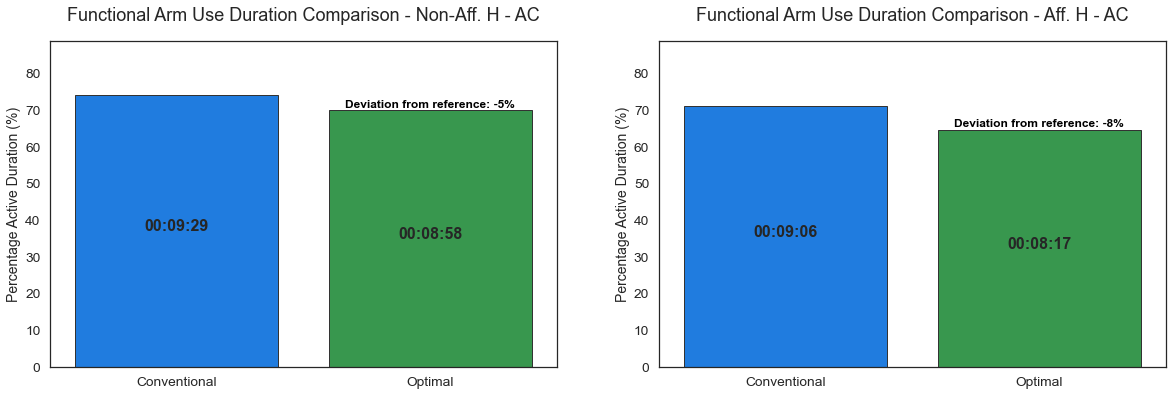

In [28]:
compare_arm_use_duration_plot_48h(ac_duration_arm_use, 'AC', save_path = None)

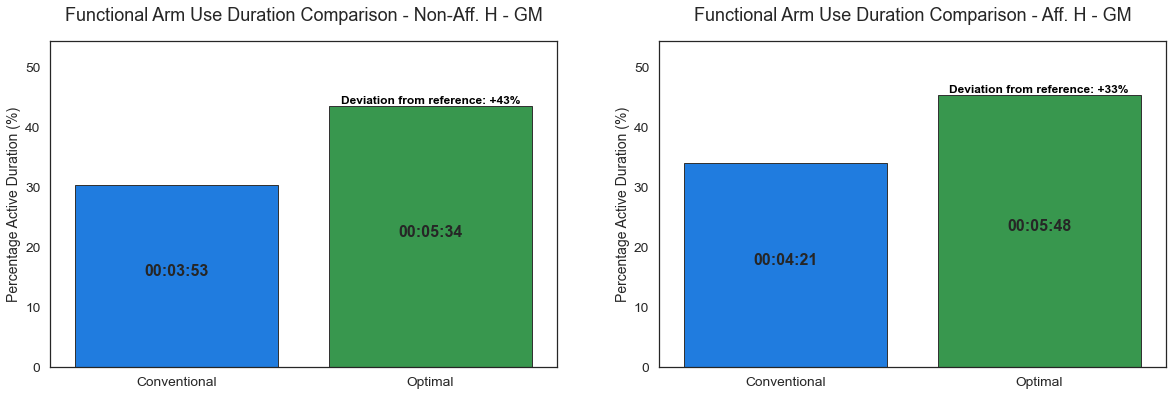

In [29]:
compare_arm_use_duration_plot_48h(gm_duration_arm_use, 'GM', save_path = None)

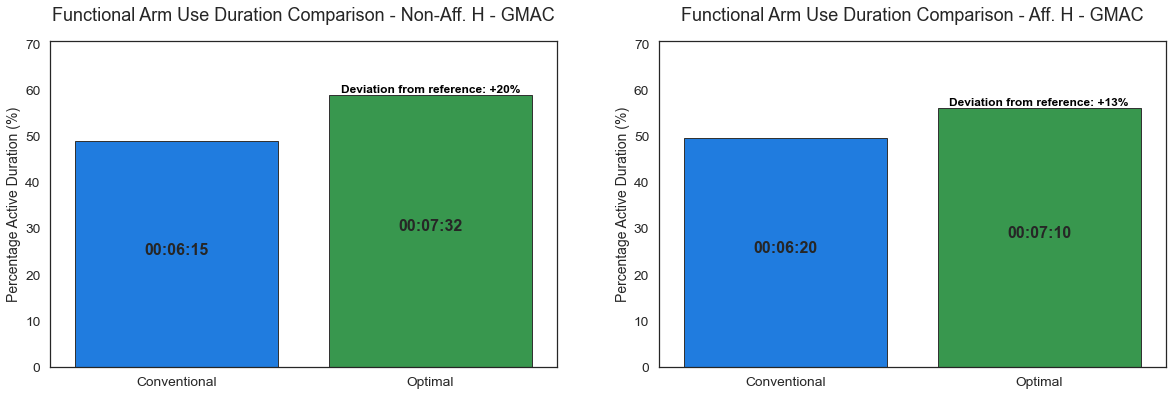

In [30]:
compare_arm_use_duration_plot_48h(gmac_duration_arm_use, 'GMAC', save_path = None)